In [16]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from relativeEfficiencyLib import *
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
import time
%matplotlib inline

In [17]:
def createMinConstAlpha():
    
    Alpha = []
    for e in np.linspace(1, 5, 11):
        
        tmp = np.linspace( e, e + 1, 10, endpoint=False)
        tmp2 = np.concatenate([[1],np.linspace( e, e + 1, 10, endpoint=False)[1:]])
        
        tmpMean = np.mean(tmp) - np.mean(tmp2)
        
        tmp2[1:] += tmpMean*(np.float(len(tmp))/len(tmp2[1:]) )
        
        Alpha.append(tmp2)
        
    return Alpha

In [18]:
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 22})

In [19]:
def ratioCorrect(n, ratio, threshold = 3.5):
    
    df = pd.DataFrame({'n':np.tile(n, ratio.shape[0]), 'ratio':ratio.flatten()})
    dfr = df[np.abs(df["ratio"]) < threshold]
    md = smf.mixedlm("ratio ~ n",dfr, groups=dfr["n"])
    mdf = md.fit()
    dfr = dfr.assign(fitted = mdf.params[0] + mdf.params[1] * dfr["n"])
    
    return [dfr, np.abs(mdf.params[1]), mdf]

In [20]:
def ratioCorrectOLS(n, ratio, threshold = 3.5):
    
    df = pd.DataFrame({'n':np.tile(n, ratio.shape[0]), 'ratio':ratio.flatten()})
    dfr = df[np.abs(df["ratio"]) < threshold]
    
    np.column_stack((np.ones(len(x)), x))
    md = smf.regression.linear_model.OLS("ratio ~ n",dfr)
    mdf = md.fit()
    dfr = dfr.assign(fitted = mdf.params[0] + mdf.params[1] * dfr["n"])
    
    return [dfr, np.abs(mdf.params[1])]

In [21]:
# outAlphaMinVar = compRelEffVarShapeVarMin(ALPHA=
#                                           [np.linspace( e, e + 1, 10, endpoint=False) for e in np.linspace(1, 5, 11)])

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]
Computing Mu,
[0.03366554309533127]
[1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3]
Computing Mu,
[0.005143829128833624]
[1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7]
Computing Mu,
[0.0007905714506032321]
[2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1]
Computing Mu,
[0.00012289987159044537]
[2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5]
Computing Mu,
[1.9252211436726e-05]
[3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9]
Computing Mu,
[3.0288733237743006e-06]
[3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3]
Computing Mu,
[4.776509454876517e-07]
[3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7]
Computing Mu,
[7.543357665280646e-08]
[4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1]
Computing Mu,
[1.1923213413973374e-08]
[4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5]
Computing Mu,
[1.885733379575356e-09]
[5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9]
Computing Mu,
[2.983602148114413e-10]


In [264]:
# import pickle as pkl
# with open("./outAlphaMinVar.pkl", "wb") as f:
    
#     pkl.dump(outAlphaMinVar, f)
    
with open("./outAlphaMinVar.pkl", "rb") as f:
    
    outAlphaMinVar = pkl.load(f)

In [263]:
from statsmodels.stats.outliers_influence import summary_table
def get_summary_table(model):
    
    df = pd.DataFrame(model.summary().tables[1].data)
    # Select first row as column names:
    df.columns = df.iloc[0, :]
    # Select first column as row names
    df.index = df.iloc[:, 0]
    # Remove the first (i.e. 0th) column and first row
    df = df.iloc[1:, 1:].astype(float)
    
    return df

def estimate_ratio_interval(n, ratio, threshold = 3.5):
    
    df = pd.DataFrame({'n':np.tile(n, ratio.shape[0]), 'ratio':ratio.flatten()})
    dfr = df[np.abs(df["ratio"]) < threshold]
    x_mat = np.column_stack((np.ones(dfr.shape[0]), dfr['n'].values))
    y = dfr['ratio'].values
    lm_fit = sm.OLS(y, x_mat).fit()

    dt = summary_table(lm_fit, alpha = 0.05)[1]
    y_fit = dt[:, 2]
    ym_ci_lower, ym_ci_upper = dt[:, 4:6].T
    
    coef = get_summary_table(lm_fit).loc['x1', 'coef']
    
    return pd.DataFrame(np.column_stack([dfr['n'].values, y_fit, ym_ci_lower, ym_ci_upper])).sort_values(0), np.abs(coef)

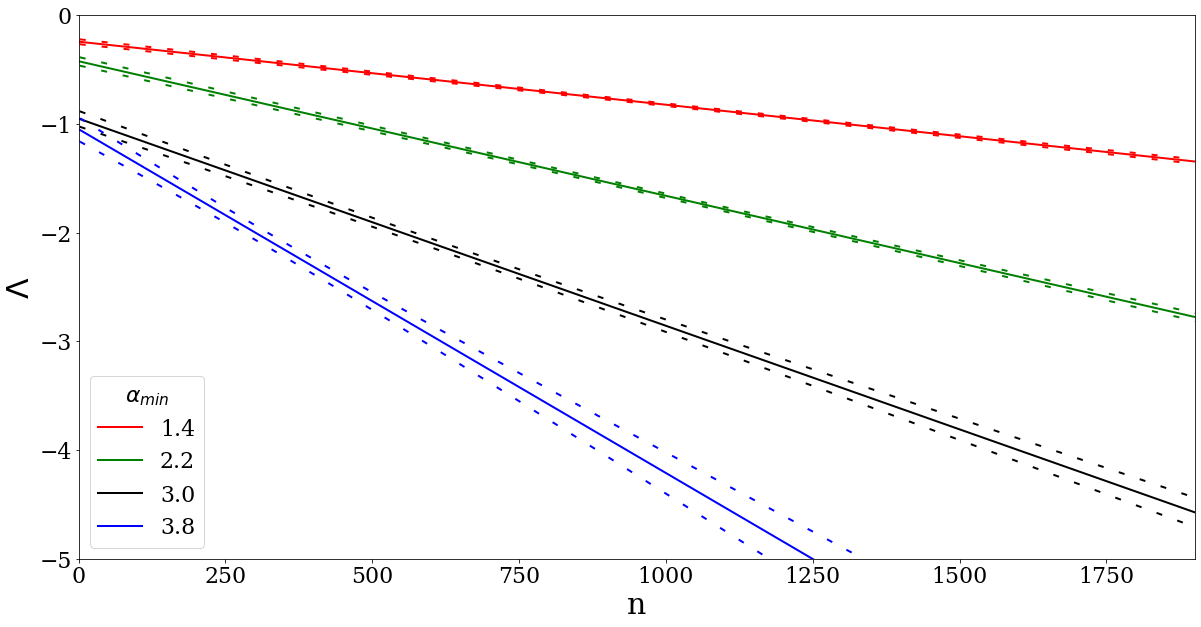

In [265]:
fig, ax = plt.subplots(figsize = [20, 10])
colors = ['blue', "black", "green", "red"]
nValues = np.linspace(1, 5, 11, endpoint= True)
table = np.zeros([len(outAlphaMinVar), 3])
for i in range(len(outAlphaMinVar)):
    
    if i in [0, 2, 4, 6, 8, 9, 10, 11, 12]:
        continue
    
    color = colors.pop()
    
    n, ratio, shape, mu, c = outAlphaMinVar[i]
    df, r = estimate_ratio_interval(n, ratio)
    ax.plot(df.iloc[:,0], df.iloc[:,1], lw=2, color=color, label = f"{nValues[i]:.1f}")
    ax.plot(df.iloc[:,0], df.iloc[:,2],
            linestyle = (0, (3, 8)), lw=2, color = color)
    ax.plot(df.iloc[:,0], df.iloc[:,3],
            linestyle = (0, (3, 8)), lw=2, color = color)
    
#     out = ratioCorrectOLS(n, ratio)
#     rLine = out[0]
#     r = out[1]
#     ax.scatter(rLine["n"], rLine["ratio"], alpha = .1, s = 5, color=colormap(normalize(nValues[i])))
#     ax.plot(rLine["n"], rLine["fitted"], alpha = .5, lw = .5, color=colormap(normalize(nValues[i])),
#             label = "".join(["c = ", str("{:.0e}".format(c))," ,mu = ", str("{:.2e}".format(mu))]))
    
#     table[i,:] = shape[0], mu, r
    
ax.set_xlim([0, 1900])
ax.set_ylim([-5, 0])
ax.set_xlabel(r'n', fontsize = 30)
ax.set_ylabel(r"$\Lambda$", fontsize = 30)
ax.legend(title=r"$\alpha_{min}$", loc='lower left')
fig.savefig("./plots.v.2.0/alphaMinVar.pdf")

In [230]:
# linestyle_str = [
#      ('solid', 'solid'),      # Same as (0, ()) or '-'
#      ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
#      ('dashed', 'dashed'),    # Same as '--'
#      ('dashdot', 'dashdot')]  # Same as '-.'

# linestyle_tuple = [
#     ('solid', (0, ())), 
#      ('loosely dotted',        (0, (1, 10))),
#      # ('dotted',                (0, (1, 1))),
#      # ('densely dotted',        (0, (1, 1))),

#      ('loosely dashed',        (0, (5, 10))),
#      # ('dashed',                (0, (5, 5))),
#      # ('densely dashed',        (0, (5, 1))),

#      ('loosely dashdotted',    (0, (3, 10, 1, 10))),
#      # ('dashdotted',            (0, (3, 5, 1, 5))),
#      # ('densely dashdotted',    (0, (3, 1, 1, 1))),

#      # ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
#      ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
#      # ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
# ]
    

In [234]:
# fig, ax = plt.subplots(figsize = [20, 10])
# nValues = np.linspace(1, 5, 11, endpoint= True)
# normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
# colormap = cm.jet
# table = np.zeros([len(outAlphaMinVar), 3])
# for i in range(len(outAlphaMinVar)):
#     n, ratio, shape, mu, c = outAlphaMinVar[i]
    
#     out = ratioCorrectOLS(n, ratio)
#     rLine = out[0]
#     r = out[1]
#     ax.scatter(rLine["n"], rLine["ratio"], alpha = .1, s = 5, color=colormap(normalize(nValues[i])))
#     ax.plot(rLine["n"], rLine["fitted"], alpha = .5, lw = .5, color=colormap(normalize(nValues[i])),
#             label = "".join(["c = ", str("{:.0e}".format(c))," ,mu = ", str("{:.2e}".format(mu))]))
    
#     table[i,:] = shape[0], mu, r
    
# ax.set_xlim([0, 2000])
# ax.set_ylim([-3.5, 0])
# ax.set_xlabel(r'n', fontsize = 30)
# ax.set_ylabel(r"$\Lambda$", fontsize = 30)
# scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappaple.set_array(nValues)
# cbar = fig.colorbar(scalarmappaple)
# cbar.set_label(r"$ \alpha_{min} $", fontsize = 30)

# fig.savefig("./plots.v.1.0/alphaMinVar.pdf")

In [236]:
outAlphaMinConst = compRelEffVarShapeVarMin(ALPHA= createMinConstAlpha())

/var/folders/dw/hbk1jb2n7p3bf06s13_8p42c0000gn/T/ipykernel_94932/3559571896.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tmp2[1:] += tmpMean*(np.float(len(tmp))/len(tmp2[1:]) )


[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]
Computing Mu,
[0.033670383901901364]
[1.         1.54444444 1.64444444 1.74444444 1.84444444 1.94444444
 2.04444444 2.14444444 2.24444444 2.34444444]
Computing Mu,
[0.013892327646434494]


/Users/omidshamssolari/workspace/Betta/cmc.py:175: RuntimeWarning: divide by zero encountered in log
  self.relEff = np.log(


[1.         1.98888889 2.08888889 2.18888889 2.28888889 2.38888889
 2.48888889 2.58888889 2.68888889 2.78888889]
Computing Mu,
[0.011093852171520986]
[1.         2.43333333 2.53333333 2.63333333 2.73333333 2.83333333
 2.93333333 3.03333333 3.13333333 3.23333333]
Computing Mu,
[0.01058427945533242]
[1.         2.87777778 2.97777778 3.07777778 3.17777778 3.27777778
 3.37777778 3.47777778 3.57777778 3.67777778]
Computing Mu,
[0.010428613595567845]
[1.         3.32222222 3.42222222 3.52222222 3.62222222 3.72222222
 3.82222222 3.92222222 4.02222222 4.12222222]
Computing Mu,
[0.010349128531371729]
[1.         3.76666667 3.86666667 3.96666667 4.06666667 4.16666667
 4.26666667 4.36666667 4.46666667 4.56666667]
Computing Mu,
[0.010296703832918502]
[1.         4.21111111 4.31111111 4.41111111 4.51111111 4.61111111
 4.71111111 4.81111111 4.91111111 5.01111111]
Computing Mu,
[0.01025833027261123]
[1.         4.65555556 4.75555556 4.85555556 4.95555556 5.05555556
 5.15555556 5.25555556 5.35555556 5

In [266]:
# import pickle as pkl
# with open("./outAlphaMinConst.pkl", "wb") as f:
    
#     pkl.dump(outAlphaMinConst, f)
    
with open("./outAlphaMinConst.pkl", "rb") as f:
    
    outAlphaMinConst = pkl.load(f)

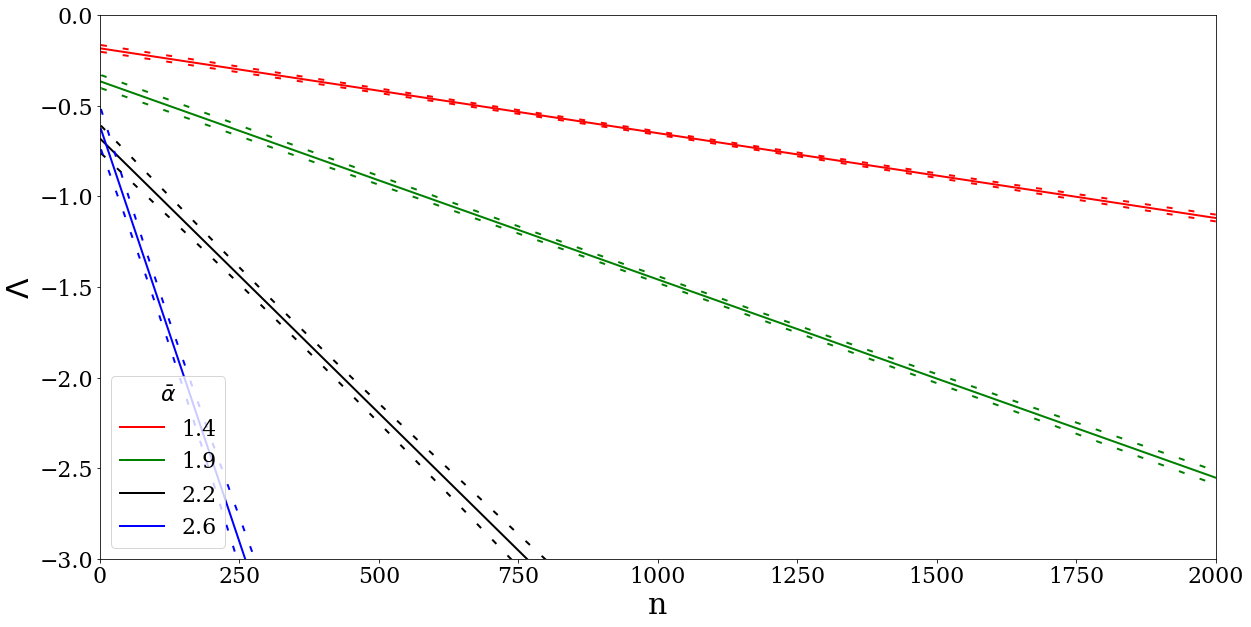

In [267]:
fig, ax = plt.subplots(figsize = [20, 10])
colors = ['blue', "black", "green", "red"]
nValues = np.array([np.round(np.mean(outAlphaMinConst[i][2]), 2) for i in range(len(outAlphaMinConst))])
table = np.zeros([len(outAlphaMinConst), 3])
for i in range(len(outAlphaMinConst)):
    
    if i not in [0,1, 2, 3]:
        continue
    
    color = colors.pop()
    
    n, ratio, shape, mu, c = outAlphaMinConst[i]
    df, r = estimate_ratio_interval(n, ratio, threshold=3)
    ax.plot(df.iloc[:,0], df.iloc[:,1], lw=2, color=color, label = f"{nValues[i]:.1f}")
    ax.plot(df.iloc[:,0], df.iloc[:,2],
            linestyle = (0, (3, 8)), lw=2, color = color)
    ax.plot(df.iloc[:,0], df.iloc[:,3],
            linestyle = (0, (3, 8)), lw=2, color = color)
    
#     out = ratioCorrectOLS(n, ratio)
#     rLine = out[0]
#     r = out[1]
#     ax.scatter(rLine["n"], rLine["ratio"], alpha = .1, s = 5, color=colormap(normalize(nValues[i])))
#     ax.plot(rLine["n"], rLine["fitted"], alpha = .5, lw = .5, color=colormap(normalize(nValues[i])),
#             label = "".join(["c = ", str("{:.0e}".format(c))," ,mu = ", str("{:.2e}".format(mu))]))
    
#     table[i,:] = shape[0], mu, r
  
ax.set_xlim([0, 2000])
ax.set_ylim([-3, 0])
ax.set_xlabel(r'n', fontsize = 30)
ax.set_ylabel(r"$\Lambda$", fontsize = 30)

ax.legend(title=r"$\bar{\alpha}$", loc='lower left')
fig.savefig("./plots.v.2.0/alphaMinConst.pdf")

In [262]:
# fig, ax = plt.subplots(figsize = [20, 10])
# nValues = np.array([np.round(np.mean(outAlphaMinConst[i][2]), 2) for i in range(len(outAlphaMinConst))])
# normalize = mcolors.Normalize(vmin=nValues.min(), vmax=nValues.max())
# colormap = cm.jet
# table = np.zeros([len(outAlphaMinConst), 3])
# for i in range(len(outAlphaMinConst)):
#     n, ratio, shape, mu, c = outAlphaMinConst[i]
    
#     out = ratioCorrectOLS(n, ratio, threshold=3)
#     rLine = out[0]
#     r = out[1]
#     ax.scatter(rLine["n"], rLine["ratio"], alpha = .1, s = 5, color=colormap(normalize(nValues[i])))
#     ax.plot(rLine["n"], rLine["fitted"], alpha = .5, lw = .5, color=colormap(normalize(nValues[i])),
#             label = "".join(["c = ", str("{:.0e}".format(c))," ,mu = ", str("{:.2e}".format(mu))]))
    
#     table[i,:] = np.mean(shape), mu, r

# ax.set_xlim([0, 2000])
# ax.set_ylim([-3, 0])
# ax.set_xlabel(r'n', fontsize = 30)
# ax.set_ylabel(r"$ log(\Lambda)$", fontsize = 30)
# scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappaple.set_array(nValues)
# cbar = fig.colorbar(scalarmappaple)
# cbar.set_label(r"$\bar{\alpha}$", fontsize = 30)

# fig.savefig("./plots.v.1.0/alphaMinConst.pdf")

In [ ]:
import pickle as pkl
pkl.dump(outAlphaMinConst, open("./simData/ourAlphaMinConst.pkl", "wb"))
pkl.dump(outAlphaMinVar, open("./simData/ourAlphaMinVar.pkl", "wb"))

In [ ]:
n, ratio, shape, mu, c = outAlphaMinConst[0]
ss =ratioCorrect(n, ratio)

In [ ]:
model.summary()

In [4]:
def timeIt(shape = np.linspace( 1, 2, 10, endpoint=False), 
                    n = np.linspace(2, 20000, 1000).astype(np.int), kappa = .01, k = 5, c = 100, verbose = False):
    
    print(shape)
    
    times = np.zeros((k, len(n), 2))
    for i in range(len(n)):
        
        tmp = CMC(shape = shape, n = n[i], c = c)
        
        for j in range(k):
            
            tmp.take_sample()
            s = time.time()
            tmp.cmc()
            e1 = time.time()
            tmp.mc()
            e2 = time.time()
            times[j, i, :] = [e1-s, e2-e1]
    
    return(n, times)

In [5]:
times160 = timeIt(n = np.linspace(5000,400000,159, endpoint=True).astype(np.int))

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]


In [6]:
n = np.linspace(5000,400000,159, endpoint=True)
times_df = pd.DataFrame(times160[1].reshape([len(n)*5, 2]))
times_df.columns = ["MC", "CMC"]
times_df["n"] = np.tile(times160[0], 5)

In [7]:
times_melt = times_df.melt(id_vars="n", value_vars=["MC", "CMC"])

In [13]:
spl = UnivariateSpline(times160[0],
                       np.log(np.mean(times160[1], 0)[:,1]) - np.log(np.mean(times160[1], 0)[:,0]))
xs = np.linspace(times160[0][0], times160[0][-1], 1000)

In [14]:
times_df = times_df.assign(logRatio = np.log(times_df["CMC"]) - np.log(times_df["MC"]))
md = smf.ols("logRatio ~ n",times_df.loc[times_df.loc[:,"n"] > 100000,:])
mdf = md.fit()
times_df = times_df.assign(fitted = mdf.params[0] + mdf.params[1] * times_df["n"])
mdf.params[1]
mdf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logRatio   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     123.7
Date:                Tue, 07 May 2019   Prob (F-statistic):           2.98e-26
Time:                        10:24:16   Log-Likelihood:                 829.76
No. Observations:                 600   AIC:                            -1656.
Df Residuals:                     598   BIC:                            -1647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7058      0.008   -617.810      0.000      -4.721      -4.691
n           3.188e-07   2.87e-08     11.123      0.000    2.63e-07    3.75e-07
==============================================================================
Omnibus:                      202.444   Durbin-Watson:                   1.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              732.622
Skew:                           1.553   Prob(JB):                    8.19e-160
Kurtosis:                       7.434   Cond. No.                     8.16e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 22})

(5000, 400000)

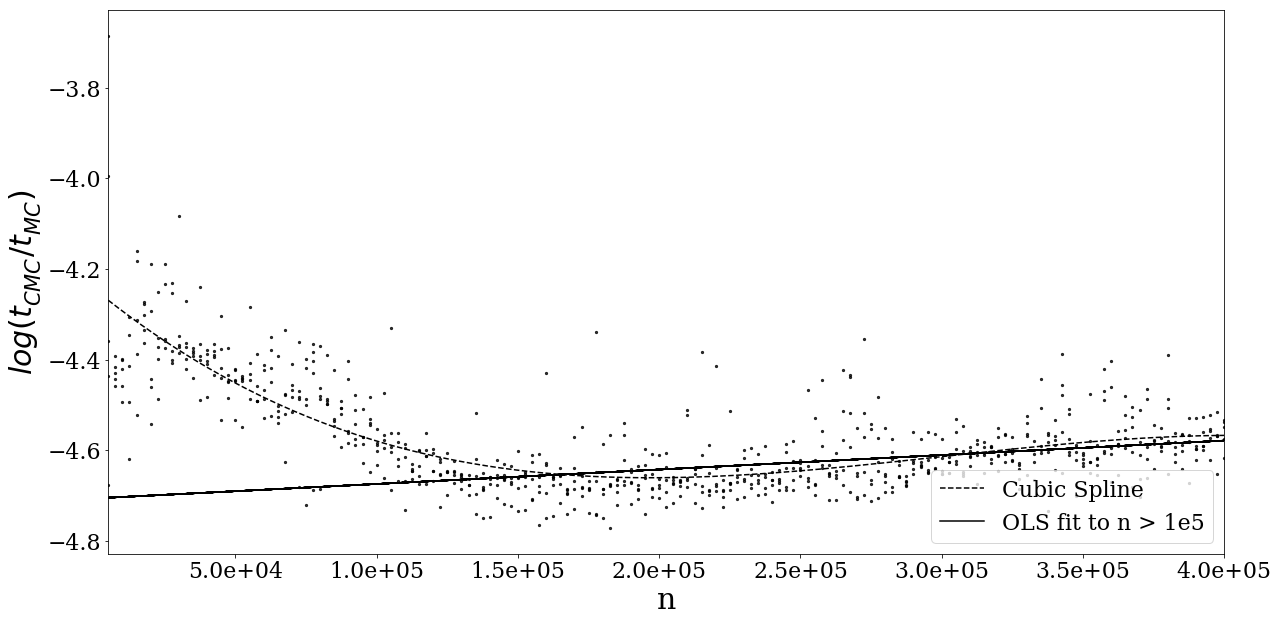

In [16]:
f, ax = plt.subplots(figsize = [20, 10])
ax.scatter(times_df["n"], y = np.log(times_df["CMC"]) - np.log(times_df["MC"]), c = "k", alpha = .8, s = 5)
#ax.plot(times160[0],np.log(np.mean(times160[1], 0)[:,1]) - np.log(np.mean(times160[1], 0)[:,0]),
#        alpha = 1, label = "mean")
ax.plot(xs, spl(xs),c = "k", ls = "dashed", label = "Cubic Spline")
ax.plot(times_df["n"], times_df["fitted"], c = "k", label = "OLS fit to n > 1e5")
ax.set_xlabel(r'n', fontsize = 30)
ax.set_ylabel(r"$ log(t_{CMC}/t_{MC})$", fontsize = 30)
ax.legend(loc = 4)
ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1e'))
ax.set_xlim([5000, 400000])

In [227]:
f.savefig("./plots.v.1.0/complexity.pdf")

In [87]:
np.log(np.mean(times[1], 0)[1]) - np.log(np.mean(times[1], 0)[0])

array([0.00587373, 0.15278331])

In [90]:
np.mean(times[1], 0)[:,1]

array([0.00221841, 0.00258461, 0.00294447, 0.00366333, 0.00383991,
       0.00424198, 0.00466461, 0.00527594, 0.0056018 , 0.00582927,
       0.00617845, 0.00706613, 0.00724617, 0.00743279, 0.00783445,
       0.00822489, 0.00869793, 0.00940874, 0.00951387, 0.01000428,
       0.01024333, 0.01092145, 0.01111697, 0.011634  , 0.01226275,
       0.0124136 , 0.0128121 , 0.01332309, 0.0143939 , 0.01478788,
       0.01481504, 0.01543914, 0.01671559, 0.01732965, 0.01677997,
       0.0172138 , 0.01804465, 0.018691  , 0.01857597, 0.01904343])